# Vision Constants Optimization

This notebook is made to optimize vision constants.

This is done by the following steps:
1. Define vision calculation functiosn - exactly the same to what are used on the bot. Check that the results produced are the same.
2. Record true values to the target and corresponding camera pixels as reference for optimization.
3. Run the optimization.
4. Test if the result is accurate.

In [27]:
# Define vision functions.
# All angles in radians, all distance in meters.
# Reference of data: https://docs.limelightvision.io/en/latest/networktables_api.html?highlight=corner#corners
# Reference Document: https://readthedocs.org/projects/limelight/downloads/pdf/latest/

import math
import numpy as np
from wpimath.geometry import Translation2d
from wpimath.geometry import Rotation2d
from matplotlib import pyplot as plt

horizontalPOV = math.radians(29.8 * 2)
verticalPOV = math.radians(24.85 * 2)
vpw = 2.0 * math.tan(horizontalPOV / 2.0) 
vph = 2.0 * math.tan(verticalPOV / 2.0)
width = 640
height = 480

targetHeight = 1.70

In [28]:

# New Version of Vision Function

class CameraPositon:
    def __init__(self, height=1.5, angle=math.radians(45.0)) -> None:
        self.height = height
        self.angle = Rotation2d(angle)
        
    def returnArray(self):
        return [self.height, self.angle.radians()]

def visionFunctionImproved(corner, goalHeight, camera_position):
    nY = -((corner[0] - width / 2.0 - 0.0) / (width / 2.0))
    nZ = -((corner[1] - height / 2.0 - 0.0) / (height / 2.0))
    
    xzPlaneTranslation = Translation2d(1.0, vph / 2.0 * nZ).rotateBy(camera_position.angle)
    
    x = xzPlaneTranslation.X()
    y = vpw / 2.0 * nY
    z = xzPlaneTranslation.Y()
    
    differentialHeight = goalHeight - camera_position.height
    if((z > 0.0) == (differentialHeight > 0.0)):
        scaling = differentialHeight / z
        distance = math.hypot(x,y) * scaling
        differential_angle = Rotation2d(x, y)
        return [distance * differential_angle.cos(), distance * differential_angle.sin()]
    else:
        return None

In [29]:
# Test Vision Function
print(visionFunctionImproved([413.5, 330.5], 1.70, CameraPositon(0.83, math.radians(30))))

[2.378162642677692, -0.4174312856610904]


In [30]:
# Recording all the measured true corresponding values as a reference for optimization
# [distance x, distance y, pixel x, pixel y]
true_values = [
    [1.0, 0.45, 60, 151],
    [1.1, 0.45, 73, 145],
    [1.2, 0.45, 77, 136],
    [1.3, 0.45, 83, 130],
    [1.4, 0.45, 88, 125],
    [1.5, 0.45, 95, 120],
    [1.6, 0.45, 96, 115],
    [1.7, 0.45, 102, 110],
    [1.8, 0.45, 102, 106],
    [1.9, 0.45, 104, 104],
    [2.0, 0.45, 108, 99],
]


In [31]:
# Define error function as the target function for optimization
def targetErrorFunctionImproved(params):
    len_height = params[0]
    horizontal = params[1]
    
    error_sum_x = 0.0
    error_sum_y = 0.0
    for value in true_values:
        estimate = visionFunctionImproved([value[2], value[3]], targetHeight, CameraPositon(len_height, horizontal))
        # Simple variance
        error_sum_x += abs(estimate[0] - value[0])
        error_sum_y += abs(estimate[1] - value[1])
    return error_sum_x + error_sum_y

In [32]:
# Test error function
print(targetErrorFunctionImproved([1.5, math.radians(20)]))

16.38900492418587


In [38]:
import scipy.optimize as optimize

# Height, Angle To Horizontal
initial_guess = [0.83, math.radians(70)]
bounds = [(0.30, 1.60), (math.radians(40.0), math.radians(85.0))]
print("Before Optimization: Height %.2f m, Angle %.2f deg" % (initial_guess[0], math.degrees(initial_guess[1])))

# Run Optimization
result = optimize.dual_annealing(targetErrorFunctionImproved, bounds=bounds)
if result.success:
    fitted_params = result.x
    print("After Optimization: Height %.2f m, Angle %.2f deg" % (fitted_params[0], math.degrees(fitted_params[1])))
else:
    raise ValueError(result.message)

Before Optimization: Height 0.83 m, Angle 70.00 deg
After Optimization: Height 0.37 m, Angle 40.00 deg


In [39]:
true_x = []
true_y = []
predicted_x = []
predicted_y = []
for value in true_values:
    true_x.append(value[0])
    true_y.append(value[1])
    
    temp = visionFunctionImproved([value[2], value[3]], targetHeight, CameraPositon(fitted_params[0], fitted_params[1]))
    predicted_x.append(temp[0])
    predicted_y.append(temp[1])


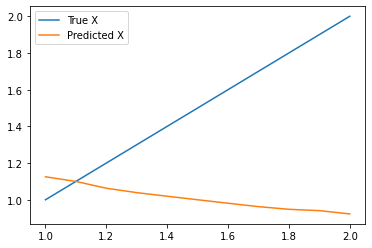

In [40]:
plt.plot(true_x, true_x, label="True X")
plt.plot(true_x, predicted_x, label="Predicted X")
plt.legend()
plt.show()

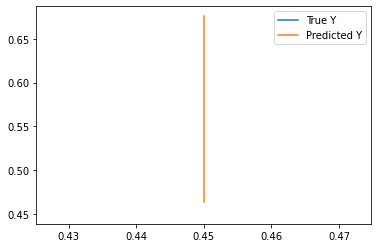

In [36]:
plt.plot(true_y, true_y, label="True Y")
plt.plot(true_y, predicted_y, label="Predicted Y")
plt.legend()
plt.show()

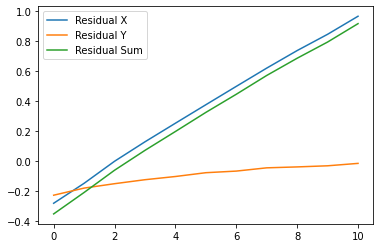

In [37]:
residual_x = np.array(true_x) - np.array(predicted_x)
residual_y = np.array(true_y) - np.array(predicted_y)
residual_sum = []
for i in range(len(true_x)):
    residual_sum.append(math.hypot(true_x[i], true_y[i]) - math.hypot(predicted_x[i], predicted_y[i]))

plt.plot(range(len(residual_x)), residual_x, label="Residual X")
plt.plot(range(len(residual_y)), residual_y, label="Residual Y")
plt.plot(range(len(residual_sum)), residual_sum, label="Residual Sum")
plt.legend()
plt.show()